In [1]:
import pandas as pd
import numpy as np

from typing import List, Tuple, Union, Dict

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import geocoder
import os
import random

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import datetime
import re
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor

from sklearn.model_selection import (
    StratifiedKFold, 
    KFold, 
    GroupKFold,    
)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

In [2]:
class Config:
    train_path = "../input/train_v2.csv"
    test_path = "../input/test_v2.csv"
    sample_submission_path = "../input/sample_submission.csv"
    output_path = "../submission/"
    seed = 42
    n_splits = 2
    mlp=False

In [3]:
random.seed(Config.seed)
os.environ['PYTHONHASHSEED'] = str(Config.seed)
np.random.seed(Config.seed)

In [4]:
df_train = pd.read_csv(Config.train_path)
df_test = pd.read_csv(Config.test_path)

In [5]:
# 雪は花粉０そうなので0
df_train.loc[df_train["pollen_utsunomiya"] == -9998, "pollen_utsunomiya"] = 0
df_train.loc[df_train["pollen_chiba"] == -9998, "pollen_chiba"] = 0
df_train.loc[df_train["pollen_tokyo"] == -9998, "pollen_tokyo"] = 0


In [6]:
# spike 除去
def remove_spike(
    df, cols=["pollen_tokyo", "pollen_utsunomiya", "pollen_chiba"], th=3, span=24
):

    _df = df.copy()
    for col in cols:
        ewm_mean = _df[col].ewm(span=span).mean()
        ewm_std = _df[col].ewm(span=span).std()

        # _df.loc[(_df[col] - ewm_mean).abs() > ewm_std * th, col] = np.nan
        print(_df.loc[(_df[col] - ewm_mean) > ewm_std * th, "datetime"].shape)
        _df.loc[(_df[col] - ewm_mean) > ewm_std * th, col] = np.nan

    return _df

#df_train = remove_spike(df_train)

In [7]:
df_train[df_train.isna().any(axis=1)].shape

(0, 16)

In [8]:
df_train.head()

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16,1,2,2.7,2.5,1.3,0.0,8.0,0.0
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1,1,1,3.3,1.5,0.9,0.0,24.0,4.0
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1,15,16,4.0,1.7,0.6,4.0,32.0,12.0
3,2017020104,0.0,0.0,0.0,-1.1,4.4,1.8,1,15,1,4.1,3.1,1.4,0.0,12.0,0.0
4,2017020105,0.0,0.0,0.0,-1.2,4.1,1.5,2,14,14,3.7,3.4,0.9,0.0,32.0,4.0


In [9]:
# 参考
# https://comp.probspace.com/competitions/pollen_counts/discussions/kotrying-Post833da695e2f337e5a86f


df_train = df_train.replace("欠測", np.nan)


df_train["precipitation_tokyo"] = df_train["precipitation_tokyo"].astype(float)
df_train["temperature_chiba"] = df_train["temperature_chiba"].astype(float)
df_train["temperature_tokyo"] = df_train["temperature_tokyo"].astype(float)

df_train["winddirection_chiba"] = df_train["winddirection_chiba"].fillna(0)
df_train["winddirection_chiba"] = df_train["winddirection_chiba"].astype(int)
df_train["winddirection_tokyo"] = df_train["winddirection_tokyo"].fillna(0)
df_train["winddirection_tokyo"] = df_train["winddirection_tokyo"].astype(int)

df_train["windspeed_chiba"] = df_train["windspeed_chiba"].astype(float)
df_train["windspeed_tokyo"] = df_train["windspeed_tokyo"].astype(float)


lgb_imp = IterativeImputer(
    estimator=LGBMRegressor(random_state=Config.seed, n_estimators=1000),
    max_iter=10,
    initial_strategy="mean",
    imputation_order="ascending",
    verbose=-1,
    random_state=Config.seed,
)

df_train = pd.DataFrame(lgb_imp.fit_transform(df_train), columns=df_train.columns)



In [10]:
#df_test = df_test.replace("欠測", np.nan)

In [11]:
df_train[df_train.isna().any(axis=1)].shape

(0, 16)

In [12]:
# 型がfloatになってしまっているので、もどす。
df_train[["winddirection_chiba", "winddirection_tokyo", "winddirection_utsunomiya"]] = (
    df_train[["winddirection_chiba", "winddirection_tokyo", "winddirection_utsunomiya"]].round().astype(int)
)
df_train[
    [
        "precipitation_tokyo",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
] = df_train[
    [
        "precipitation_tokyo",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
].round(
    1
)
df_train["datetime"] = df_train["datetime"].astype(int)

# df_train[df_train.select_dtypes(object).columns] = df_train[df_train.select_dtypes(object).columns]
df_train.head(3)

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16,1,2,2.7,2.5,1.3,0.0,8.0,0.0
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1,1,1,3.3,1.5,0.9,0.0,24.0,4.0
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1,15,16,4.0,1.7,0.6,4.0,32.0,12.0


In [13]:
loc_list = ["宇都宮市中央生涯学習センター", "千葉県環境研究センター", "東京都多摩小平保健所"]

utsunomiya = "utsunomiya"
chiba = "chiba"
tokyo = "tokyo"

key_list = [utsunomiya, chiba, tokyo]

LATLNG_DICT = {}

try:

    for i, key in zip(loc_list, key_list):
        loc = geocoder.osm(i, timeout=5.0)
        print(loc.latlng)
        print(loc.address)
        LATLNG_DICT[key] = tuple(loc.latlng)

    LOC_VECTOR_DICT = {
        (utsunomiya, tokyo): np.array(LATLNG_DICT[utsunomiya])
        - np.array(LATLNG_DICT[tokyo]),
        (utsunomiya, chiba): np.array(LATLNG_DICT[utsunomiya])
        - np.array(LATLNG_DICT[chiba]),
        (chiba, tokyo): np.array(LATLNG_DICT[chiba]) - np.array(LATLNG_DICT[tokyo]),
        (chiba, utsunomiya): np.array(LATLNG_DICT[chiba])
        - np.array(LATLNG_DICT[utsunomiya]),
        (tokyo, chiba): np.array(LATLNG_DICT[tokyo]) - np.array(LATLNG_DICT[chiba]),
        (tokyo, utsunomiya): np.array(LATLNG_DICT[tokyo])
        - np.array(LATLNG_DICT[utsunomiya]),
    }

    print(LATLNG_DICT)
    print(LOC_VECTOR_DICT)

except Exception as e:
    print(e)
    print("APIでのデータ取得に失敗したため、成功時に取得したデータを使います。")
    LATLNG_DICT = {
        "utsunomiya": (36.5594462, 139.88265145),
        "chiba": (35.633642, 140.077749),
        "tokyo": (35.7298652, 139.51664115548698),
    }
    LOC_VECTOR_DICT = {
        ("utsunomiya", "tokyo"): np.array([0.829581, 0.36601029]),
        ("utsunomiya", "chiba"): np.array([0.9258042, -0.19509755]),
        ("chiba", "tokyo"): np.array([-0.0962232, 0.56110784]),
        ("chiba", "utsunomiya"): np.array([-0.9258042, 0.19509755]),
        ("tokyo", "chiba"): np.array([0.0962232, -0.56110784]),
        ("tokyo", "utsunomiya"): np.array([-0.829581, -0.36601029]),
    }

[36.5594462, 139.88265145]
宇都宮市 中央生涯学習センター, 中央通り, 中央一丁目, 宇都宮市, 栃木県, 320-0802, 日本
[35.633642, 140.077749]
千葉県環境研究センター, 海浜松風通り, 高浜五丁目, 美浜区, 千葉市, 千葉県, 261-0004, 日本
[35.7298652, 139.51664115548698]
東京都多摩小平保健所, 青梅街道, 芝久保町, 小平市, 東京都, 188-0014, 日本
{'utsunomiya': (36.5594462, 139.88265145), 'chiba': (35.633642, 140.077749), 'tokyo': (35.7298652, 139.51664115548698)}
{('utsunomiya', 'tokyo'): array([0.829581  , 0.36601029]), ('utsunomiya', 'chiba'): array([ 0.9258042 , -0.19509755]), ('chiba', 'tokyo'): array([-0.0962232 ,  0.56110784]), ('chiba', 'utsunomiya'): array([-0.9258042 ,  0.19509755]), ('tokyo', 'chiba'): array([ 0.0962232 , -0.56110784]), ('tokyo', 'utsunomiya'): array([-0.829581  , -0.36601029])}


# Feature

In [14]:
# 時間
def to_datetime(time: datetime.datetime) -> datetime.datetime:
    time = str(time)
    try:
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
    except ValueError:
        time = re.sub("24$", "23", time)
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
        time += datetime.timedelta(hours=1)
    return time


def time_feat(df: pd.DataFrame) -> pd.DataFrame:
    df["datetime_dt"] = df["datetime"].apply(to_datetime)
    df["year"] = df["datetime_dt"].dt.year
    df["month"] = df["datetime_dt"].dt.month
    df["day"] = df["datetime_dt"].dt.day
    df["hour"] = df["datetime_dt"].dt.hour
    df["hour_sin"] = np.sin(df["datetime_dt"].dt.hour * (2 * np.pi / (24 + 1)))
    df["hour_cos"] = np.cos(df["datetime_dt"].dt.hour * (2 * np.pi / (24 + 1)))
    df["weekday"] = df["datetime_dt"].dt.weekday
    df["day_of_year"] = df["datetime_dt"].dt.dayofyear
    df["day_sin"] = np.sin(df["day_of_year"] * (2 * np.pi / (365 + 1)))
    df["day_cos"] = np.cos(df["day_of_year"] * (2 * np.pi / (365 + 1)))

    df["month_sin"] = np.sin(df["month"] * (2 * np.pi / (12 + 1)))
    df["month_cos"] = np.cos(df["month"] * (2 * np.pi / (12 + 1)))

    df["day_sin_sum_hour_sin"] = df["day_sin"] + df["hour_sin"]
    df["day_cos_sum_hour_cos"] = df["day_sin"] + df["hour_cos"]

    df["day_sin_sum_hour_sin_sum_month_sin"] = (
        df["day_sin"] + df["hour_sin"] + df["month_sin"]
    )
    df["day_cos_sum_hour_cos_sum_month_cos"] = (
        df["day_sin"] + df["hour_cos"] + df["month_cos"]
    )

    df["hour_sin_sum_month_sin"] = df["hour_sin"] + df["month_sin"]
    df["hour_cos_sum_month_cos"] = df["hour_cos"] + df["month_cos"]

    df["day_sin_mult_hour"] = df["day_sin"] * (1 + df["hour"] / 24)
    df["day_cos_mult_hour"] = df["day_cos"] * (1 + df["hour"] / 24)

    df["day_sin_mult_hour_mult_month"] = (
        df["day_sin"] * (1 + df["hour"] / 24) * (1 + df["month"] / 13)
    )
    df["day_cos_mult_hour_mult_month"] = (
        df["day_cos"] * (1 + df["hour"] / 24) * (1 + df["month"] / 13)
    )

    #     df["day_sin_mulit_hour_sin"] = df["hour_sin"] * df["day_sin"]
    #     df["day_sin_mulit_hour_cos"] = df["hour_cos"] * df["day_cos"]

    #     df["day_sin_sum_hour_sin"] = df["hour_sin"] + df["day_sin"]
    #     df["day_sin_sum_hour_cos"] = df["hour_cos"] + df["day_cos"]

    #     df["day_sin_mulit_hour_sin_mult_month"] = df["hour_sin"] * df["day_sin"] * (df["month"] / 12)
    #     df["day_sin_mulit_hour_cos_mult_month"] = df["hour_cos"] * df["day_cos"] * (df["month"] / 12)

    #     df["day_sin_sum_hour_sin_mult_month"] = df["hour_sin"] + df["day_sin"] * (df["month"] / 12)
    #     df["day_sin_sum_hour_cos_mult_month"] = df["hour_cos"] + df["day_cos"] * (df["month"] / 12)

    # for col in ["temperature_tokyo", "temperature_utsunomiya", "temperature_chiba"]:

    #     df[f"month_sin_mult_temperature_{col}"] = df[col] * df["month_sin"]
    #     df[f"month_cos_mult_temperature_{col}"] = df[col] * df["month_cos"]

    #     df[f"day_sin_sum_hour_sin_sum_month_sin_mult_temperature_{col}"] = df[col] * df["day_sin_sum_hour_sin_sum_month_sin"]
    #     df[f"day_sin_sum_hour_sin_sum_month_sin_mult_temperature_{col}"] = df[col] * df["day_sin_sum_hour_sin_sum_month_sin"]

    return df


# ラグ特徴/ローリング特徴量
def add_lag_feat(df: pd.DataFrame, feat: List[str], group: str) -> pd.DataFrame:
    outputs = [df]

    grp_df = df.groupby(group)  # year ごとにシフトする。 各年1~6月期間しかないのでこのようにする。

    for lag in [1, 2, 3, 4, 5]:
    #for lag in list(range(1, 25)):
        # shift
        outputs.append(grp_df[feat].shift(lag).add_prefix(f"shift{lag}_"))
        # diff
        outputs.append(grp_df[feat].diff(lag).add_prefix(f"diff{lag}_"))

    # rolling
    windows = [3] + [i * 24 for i in range(1, 10)]
    for window in windows:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f"rolling{window}_mean_")
        outputs.append(tmp_df.reset_index(drop=True))

    _df = pd.concat(outputs, axis=1)
    return _df


def add_lag_feat_one_year(df: pd.DataFrame, feat: List[str]) -> pd.DataFrame:
    outputs = [df]
    prefix = "shift_one_year_"
    outputs.append(df[feat].shift(3600).add_prefix(prefix))

    df = pd.concat(outputs, axis=1)
    outputs = [df]
    cols = [f"{prefix}{col}" for col in feat]

    for window in [3] + [i * 24 for i in range(1, 10)]:
        outputs.append(
            df[cols].rolling(window, min_periods=1).mean().add_prefix(f"roll_{window}_")
        )

    df = pd.concat(outputs, axis=1)
    return df


# 集計特徴
def additional_encoding(
    train: pd.DataFrame, test: pd.DataFrame, cat_col: List[str], num_col: List[str]
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    trdf = train.copy()
    tedf = test.copy()

    # Count Encoding
    for ccol in cat_col:
        encoder = trdf[(trdf["month"] == 4) & (trdf["day"] < 15)][ccol].value_counts()
        trdf[f"ce_{ccol}"] = trdf[ccol].map(encoder)
        tedf[f"ce_{ccol}"] = tedf[ccol].map(encoder)

    # Add Aggregate Features
    agg_cols = ["mean", "std", "min", "max"]
    for ccol in cat_col:
        for ncol in num_col:
            agg_df = trdf.groupby(ccol)[ncol].agg(agg_cols)
            agg_df["abs_mean"] = np.abs(agg_df["mean"])
            agg_df["min_max"] = agg_df["min"] * agg_df["max"]
            agg_df.columns = [f"{ccol}_{c}" for c in agg_df.columns]
            trdf = trdf.merge(agg_df, on=ccol, how="left")
            tedf = tedf.merge(agg_df, on=ccol, how="left")

    return trdf, tedf


def add_wind_direction_one_hot(df: pd.DataFrame) -> pd.DataFrame:

    cols = [
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ]

    num_wind_direction = 17

    dfs = []
    for col in cols:
        data = {f"{col}_one_hot_{i}": [] for i in range(num_wind_direction)}
        for x in df[col].astype(int):
            for i in range(num_wind_direction):
                if x == i:
                    data[f"{col}_one_hot_{i}"].append(1)
                else:
                    data[f"{col}_one_hot_{i}"].append(0)

        _df = pd.DataFrame(data)
        dfs.append(_df)

    return pd.concat([df] + dfs, axis=1)


def add_wind_direction_to_cos_sin(df: pd.DataFrame) -> pd.DataFrame:
    """
    {col} が 0：静穏 の場合 {col}_cos, {col}_sinには、欠損になる
    1：北北東
    2：北東
    3：東北東
    4：東
    5：東南東
    6：南東
    7：南南東
    8：南
    9：南南西
    10：南西
    11：西南西
    12：西
    13：西北西
    14：北西
    15：北北西
    16：北

    """
    df_origin = df.copy()

    direction_map = {
        1: 13,
        2: 14,
        3: 15,
        4: 0,
        5: 1,
        6: 2,
        7: 3,
        8: 4,
        9: 5,
        10: 6,
        11: 7,
        12: 8,
        13: 9,
        14: 10,
        15: 11,
        16: 12,
    }

    pref_list = [utsunomiya, tokyo, chiba]

    for col in [
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ]:

        _df = df_origin[[col]].copy()
        _df = _df.reset_index()
        _df = _df[_df[col] != 0].reset_index(drop=True)  # 0：静穏 は風の方向ではないので消す
        # _df[col] = _df[col] - 1  # 1 ~ 16 なので 0 ~ 15に変換
        _df[col] = _df[col].apply(lambda x: direction_map[x])

        _df[f"{col}_cos"] = np.cos(2 * np.pi * _df[col] / (_df[col].max() + 1))
        _df[f"{col}_sin"] = np.sin(2 * np.pi * _df[col] / (_df[col].max() + 1))
        _df = _df.drop(col, axis=1)

        target_pref = col.split("_")[1]
        other_pref = list(set(pref_list) - set([target_pref]))

        # 内積 window directionベクトル と 他県へのベクトル
        _df[f"{col}_ip_wind_loc_{other_pref[0]}"] = (
            _df[f"{col}_cos"] * LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
            + _df[f"{col}_sin"] * LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
        )

        _df[f"{col}_ip_wind_loc_{other_pref[1]}"] = (
            _df[f"{col}_cos"] * LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
            + _df[f"{col}_sin"] * LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
        )

        # なす角のcos/arc cos  window directionベクトル と 他県へのベクトル
        _df[f"{col}_cos_wind_loc_{other_pref[0]}"] = _df[
            f"{col}_ip_wind_loc_{other_pref[0]}"
        ] / (
            (
                np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
            )
            * (
                np.sqrt(
                    LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
                    * LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
                )
                + np.sqrt(
                    LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
                    * LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
                )
            )
        )

        _df[f"{col}_arc_cos_wind_loc_{other_pref[0]}"] = (
            _df[f"{col}_ip_wind_loc_{other_pref[0]}"]
            / (
                (
                    np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                    + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
                )
                * (
                    np.sqrt(
                        LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
                        * LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
                    )
                    + np.sqrt(
                        LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
                        * LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
                    )
                )
            )
        ).apply(lambda x: np.degrees(np.arccos(x)))

        _df[f"{col}_cos_wind_loc_{other_pref[1]}"] = _df[
            f"{col}_ip_wind_loc_{other_pref[1]}"
        ] / (
            (
                np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
            )
            * (
                np.sqrt(
                    LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
                    * LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
                )
                + np.sqrt(
                    LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
                    * LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
                )
            )
        )

        _df[f"{col}_arc_cos_wind_loc_{other_pref[1]}"] = _df[
            f"{col}_ip_wind_loc_{other_pref[1]}"
        ] / (
            (
                np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
            )
            * (
                np.sqrt(
                    LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
                    * LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
                )
                + np.sqrt(
                    LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
                    * LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
                )
            )
        ).apply(
            lambda x: np.degrees(np.arccos(x))
        )

        df_origin = df_origin.reset_index()
        df_origin = df_origin.merge(_df, on="index", how="left")
        df_origin = df_origin.drop("index", axis=1)
        df_origin[f"{col}_no_window"] = (df_origin[col] == 0).astype(int)

        # cos/sin x 風速
        pref = col.split("_")[-1]
        df_origin[f"{col}_cos_mult_window_speed"] = (
            df_origin[f"windspeed_{pref}"] * df_origin[f"{col}_cos"]
        )  # .fillna(0)
        df_origin[f"{col}_sin_mult_window_speed"] = (
            df_origin[f"windspeed_{pref}"] * df_origin[f"{col}_sin"]
        )  # .fillna(0)

        df_origin[f"{col}_cos_mult_window_speed_mult_precipitation"] = df_origin[
            f"{col}_cos_mult_window_speed"
        ] * (1 / (1 + df_origin[f"precipitation_{pref}"]))

        df_origin[f"{col}_sin_mult_window_speed_mult_precipitation"] = df_origin[
            f"{col}_sin_mult_window_speed"
        ] * (1 / (1 + df_origin[f"precipitation_{pref}"]))

        df_origin[
            f"{col}_cos_mult_window_speed_mult_precipitation_mult_day_hour_cos"
        ] = (
            df_origin[f"{col}_cos_mult_window_speed"]
            * (1 / (1 + df_origin[f"precipitation_{pref}"]))
            * df_origin["day_sin_mult_hour_mult_month"]
            #             * df_origin["day_sin_mulit_hour_sin_mult_month"]
        )

        df_origin[
            f"{col}_sin_mult_window_speed_mult_precipitation_mult_day_hour_sin"
        ] = (
            df_origin[f"{col}_sin_mult_window_speed"]
            * (1 / (1 + df_origin[f"precipitation_{pref}"]))
            * df_origin["day_sin_mult_hour_mult_month"]
            #             * df_origin["day_sin_mulit_hour_sin_mult_month"]
        )

        df_origin[f"{col}_cos_mult_window_speed_loc_{other_pref[0]}"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_cos"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[0]}"]
        )
        df_origin[f"{col}_sin_mult_window_speed"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_sin"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[0]}"]
        )

        df_origin[f"{col}_cos_mult_window_speed_loc_{other_pref[1]}"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_cos"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[1]}"]
        )
        df_origin[f"{col}_sin_mult_window_speed"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_sin"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[1]}"]
        )

    # 全体の和　全体の風向きを期待。
    df_origin[f"window_vector_cos_mult_precipitation"] = (
        df_origin[f"winddirection_utsunomiya_cos_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_tokyo_cos_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_chiba_cos_mult_window_speed_mult_precipitation"]
    )
    df_origin[f"window_vector_sin_mult_precipitation"] = (
        df_origin[f"winddirection_utsunomiya_sin_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_tokyo_sin_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_chiba_sin_mult_window_speed_mult_precipitation"]
    )

    return df_origin


def remove_noise(
    df: pd.DataFrame, window_length: int, polyorder: int = 2, overwite: bool = False
) -> pd.DataFrame:
    _df = df.copy()
    cols = [
        "precipitation_utsunomiya",
        "precipitation_chiba",
        "precipitation_tokyo",
        "temperature_utsunomiya",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_utsunomiya",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
    for col in cols:
        # _df[f"{col}_smooth_{window_length}"] = savgol_filter(_df[col])
        if overwite:
            _df[col] = savgol_filter(
                _df[col], window_length=window_length, polyorder=polyorder
            )
        else:
            _df[f"{col}_smooth_{window_length}"] = savgol_filter(
                _df[col], window_length=window_length, polyorder=polyorder
            )
            _df.loc[
                _df[f"{col}_smooth_{window_length}"] < 0,
                f"{col}_smooth_{window_length}",
            ] = 0

    return _df


def add_precipitation_zero_count_feat(df: pd.DataFrame) -> pd.DataFrame:
    # https://comp.probspace.com/competitions/pollen_counts/discussions/saru_da_mon-Post5943fd8142f960c070d7

    th = 0.5
    for pref in ["utsunomiya", "chiba", "tokyo"]:
        count_list_all = []
        for year in [2017, 2018, 2019, 2020]:
            _df = df[df.year == year].reset_index(drop=True)
            count_list_by_year = []
            n_count = 0
            for e in _df[f"precipitation_{pref}"]:
                if e < th:
                    n_count += 1
                else:
                    n_count = 0
                count_list_by_year.append(np.log1p(n_count))
            count_list_all.extend(count_list_by_year)
        df[f"precipitation_{pref}_count_{th}_2"] = count_list_all

    return df


def temperature_flag(df: pd.DataFrame) -> pd.DataFrame:
    # https://www.allegra.jp/hayfever/how_predict.html
    # 気温が30℃を超え日照時間が多いと花芽が多く作られ、翌年春の花粉飛散量は多くなります。
    # 逆に最高気温が25℃程度にしかならないいわゆる「冷夏」では、木は花芽ではなく枝を伸ばすことに注力するため、
    # 翌年春の花粉飛散量は少なくなります。

    # 30度超えたかのフラグ
    cols = ["temperature_utsunomiya", "temperature_chiba", "temperature_tokyo"]

    for col in cols:
        for th in [20, 25, 30]:
            df[f"{col}_over_{th}"] = (df[col] > th).astype(int)

    return df


def add_sekisan_ondo(
    df: pd.DataFrame,
    cols: List[str] = [
        "temperature_utsunomiya",
        "temperature_tokyo",
        "temperature_chiba",
    ],
) -> pd.DataFrame:
    # https://hp.otenki.com/401/
    # 1/1からの毎日の温度の平均を和を算出していく

    dfs = []
    for year in [2017, 2018, 2019, 2020]:
        _df = df[df.year == year].copy()
        _df["ymd"] = _df["datetime_dt"].apply(lambda x: x.strftime("%Y%m%d"))

        for col in cols:
            _df_temp_mean = _df[["ymd", col]].groupby("ymd").max().reset_index()
            _df_temp_mean = _df_temp_mean.rename(columns={col: f"{col}_daily_mean"})
            _df_temp_mean[f"sekisan_ondo_{col}"] = _df_temp_mean[
                f"{col}_daily_mean"
            ].cumsum()
            _df = _df.merge(_df_temp_mean, on="ymd", how="inner")

        _df = _df.drop("ymd", axis=1)
        dfs.append(_df)

    _df = pd.concat(dfs)

    return _df


def add_sekisan_ondo2(
    df: pd.DataFrame,
    cols: List[str] = [
        "temperature_utsunomiya",
        "temperature_tokyo",
        "temperature_chiba",
    ],
) -> pd.DataFrame:
    # https://hp.otenki.com/401/
    # 1/1からの毎日の温度の平均を和を算出していく

    dfs = []
    for year in [2017, 2018, 2019, 2020]:
        _df = df[df.year == year].reset_index(drop=True).copy()
        # _df["ymd"] = _df["datetime_dt"].apply(lambda x: x.strftime("%Y%m%d"))

        for col in cols:
            _df.loc[_df[col] < 0, col] = 0
            s = _df[col].sum()
            _df[f"sekisan_ondo_{col}_2"] = _df[col].cumsum()
            #_df[f"sekisan_ondo_{col}_2_ratio"] = _df[f"sekisan_ondo_{col}_2"] / s
        dfs.append(_df)

    _df = pd.concat(dfs)

    return _df

def temperature_decompose(df: pd.DataFrame) -> pd.DataFrame:
    from statsmodels.tsa.seasonal import STL

    _df = df.copy()
    for col in ["temperature_tokyo", "temperature_utsunomiya", "temperature_chiba"]:
        res = STL(_df[col], period=24).fit()
        _df[f"{col}_decompose_trend"] = res.trend
        _df[f"{col}_decompose_seasonal"] = res.seasonal
        _df[f"{col}_decompose_resid"] = res.resid
        _df[f"{col}_decompose_minus_trend"] = _df[col] - _df[f"{col}_decompose_trend"]

    return _df


def add_precipitation_mult_month(df: pd.DataFrame) -> pd.DataFrame: 
    _df = df.copy()
    for col in ["precipitation_tokyo", "precipitation_chiba", "precipitation_tokyo"]: 
        _df[f"{col}_mult_month"] = _df[col] * (1 / _df["month"])        

    return _df

def make_feature(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = time_feat(df)

    # 降水量カウント
    df = add_precipitation_zero_count_feat(df)

    df = remove_noise(df, window_length=7, overwite=False)
    df = remove_noise(df, window_length=13, overwite=False)
    df = remove_noise(df, window_length=25, overwite=False)
    # df = remove_noise(df, window_length=(24 * 7 + 1), overwite=False)

    # ラグ特徴の追加
    feat = [
        "precipitation_utsunomiya",
        "precipitation_chiba",
        "precipitation_tokyo",
        "temperature_utsunomiya",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_utsunomiya",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
    df = add_lag_feat(df, feat, "year")
    
    # ノイズ除去でラグ
    feat_smooth = [col for col in df.columns if "_smooth" in col]
    df = add_lag_feat(df, feat_smooth, "year")

    # 風 one-hot
    df = add_wind_direction_one_hot(df)

    # 風
    df = add_wind_direction_to_cos_sin(df)
    feat_window = [
        f
        for f in df.columns
        if ("cos_mult_window_speed" in f)
        or ("sin_mult_window_speed" in f)
        or ("mult_precipitation" in f)
    ]
    df = add_lag_feat(df, feat_window, "year")

    # 積算温度
    df = add_sekisan_ondo(df)
    #df = add_sekisan_ondo2(df) #mlp dowen

    # 1年ラグ
    df = add_lag_feat_one_year(df, feat)

    # over
    df = temperature_flag(df)
    temp_over_feat = [f for f in df.columns if "_over_" in f]
    df = add_lag_feat_one_year(df, temp_over_feat)

    # decompose
    df = temperature_decompose(df.reset_index(drop=True))
    decompose_feat = [f for f in df.columns if "_decompose_" in f]
    df = add_lag_feat(df, decompose_feat, "year")

    #df = add_precipitation_mult_month(df)
    df = df.drop([
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ], axis=1)
    # df = add_lag_feat_one_year(df, feat_smooth_7)
    # df = add_lag_feat_one_year(df, feat_smooth_13)
    # df = add_lag_feat_one_year(df, feat_smooth_25)
    # df = add_lag_feat_one_year(df, feat_window)    

    return df

In [15]:
df_train.shape, df_test.shape

((12240, 16), (336, 16))

In [16]:
df_test["pollen_utsunomiya"] = -1
df_test["pollen_chiba"] = -1
df_test["pollen_tokyo"] = -1

_df_tmp = pd.concat([df_train, df_test]).reset_index(drop=True)

_df_feat = make_feature(_df_tmp)

_df = _df_feat[_df_feat["pollen_utsunomiya"] != -1].reset_index(drop=True)
_df_test = _df_feat[_df_feat["pollen_utsunomiya"] == -1].reset_index(drop=True)

#_df = _df.reset_index(drop=True)
#_df_test = _df_test.reset_index(drop=True)

_df_test = _df_test.drop(["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"], axis=1)

In [17]:
_df.shape, _df_test.shape

((12240, 1875), (336, 1872))

# 一週間ごとに集約

In [18]:
_df_agg = _df.copy()
_df_test_agg = _df_test.copy()
_df_agg = _df_agg.fillna(0)
_df_test_agg = _df_test_agg.fillna(0)

print(_df_agg.isna().any().any())
print(_df_test_agg.isna().any().any())


def add_time_info(_df):
    _df["day"] = (_df["datetime"] % 10000) // 100
    _df["ym"] = _df["datetime"].astype(str).apply(lambda x: x[:6])
    # one week
    _df["ymd"] = _df["ym"] + _df["day"].apply(lambda x: f"week_{(x - 1) // 7}")

    return _df


_df_agg = add_time_info(_df_agg)
_df_test_agg = add_time_info(_df_test_agg)

cols = [
    col
    for col in _df_agg.columns
    if col
    not in [
        "datetime",
        "datetime_dt",
        "day",
        "pollen_utsunomiya",
        "pollen_chiba",
        "pollen_tokyo",
    ]
]

# train
df_ymd = _df_agg[cols+ ["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"]].groupby("ymd").sum()
df_ymd_mean = _df_agg[cols].groupby("ymd").mean()
df_ymd = pd.concat([df_ymd, df_ymd_mean.add_prefix("mean")], axis=1)

_df_ymd_count = _df_agg[["ymd", "pollen_tokyo"]].groupby("ymd").count().reset_index().rename(columns={"pollen_tokyo": "count"})
_df_ymd_count = _df_ymd_count[_df_ymd_count["count"] >= 168].reset_index(drop=True)
df_ymd = df_ymd.reset_index().merge(_df_ymd_count[["ymd"]], on="ymd", how="inner").set_index("ymd")

#test
df_ymd_test = _df_test_agg[cols].groupby("ymd").sum()
df_ymd_test_mean = _df_test_agg[cols].groupby("ymd").mean()
df_ymd_test = pd.concat([df_ymd_test, df_ymd_test_mean.add_prefix("mean")], axis=1)


print(df_ymd.isna().any().any())
print(df_ymd_test.isna().any().any())


False
False
False
False


In [19]:
df_ymd.head()

,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,year,...,meanrolling216_mean_temperature_tokyo_decompose_resid,meanrolling216_mean_temperature_tokyo_decompose_minus_trend,meanrolling216_mean_temperature_utsunomiya_decompose_trend,meanrolling216_mean_temperature_utsunomiya_decompose_seasonal,meanrolling216_mean_temperature_utsunomiya_decompose_resid,meanrolling216_mean_temperature_utsunomiya_decompose_minus_trend,meanrolling216_mean_temperature_chiba_decompose_trend,meanrolling216_mean_temperature_chiba_decompose_seasonal,meanrolling216_mean_temperature_chiba_decompose_resid,meanrolling216_mean_temperature_chiba_decompose_minus_trend
ymd,,,,,,,,,,,,,,,,,,,,,
201702week_0,0.5,0.5,0.0,669.5,1243.9,1008.5,547.1,793.3,278.9,338856,...,-0.046783,-0.287330,3.530968,-0.423378,-0.074259,-0.497637,6.957306,-0.303589,0.059838,-0.243751
201702week_1,3.5,7.5,6.0,393.4,929.4,696.1,551.5,643.3,238.3,338856,...,0.000022,-0.007613,3.418571,-0.019628,-0.001409,-0.021036,6.656431,-0.012597,0.006305,-0.006292
201702week_2,1.0,18.0,7.5,894.7,1455.9,1198.1,578.9,892.6,299.2,338856,...,-0.002644,-0.004163,3.593376,-0.001457,-0.002112,-0.003569,6.934357,-0.000887,-0.001564,-0.002451
201702week_3,2.5,1.0,0.0,923.4,1333.1,1198.3,479.1,681.4,321.0,338856,...,0.000063,0.000239,5.441552,0.000608,0.000185,0.000793,8.657095,0.000142,0.002612,0.002754
201703week_0,3.5,27.0,10.5,1073.9,1426.3,1226.9,470.5,432.7,246.7,338856,...,0.003692,0.004725,5.702003,0.000438,0.003214,0.003652,7.787971,0.000298,0.000882,0.001180


In [20]:
df_ymd.head().T


ymd,201702week_0,201702week_1,201702week_2,201702week_3,201703week_0
precipitation_utsunomiya,0.500000,3.500000,1.000000,2.500000,3.500000
precipitation_chiba,0.500000,7.500000,18.000000,1.000000,27.000000
precipitation_tokyo,0.000000,6.000000,7.500000,0.000000,10.500000
temperature_utsunomiya,669.500000,393.400000,894.700000,923.400000,1073.900000
temperature_chiba,1243.900000,929.400000,1455.900000,1333.100000,1426.300000
...,...,...,...,...,...
meanrolling216_mean_temperature_utsunomiya_decompose_minus_trend,-0.497637,-0.021036,-0.003569,0.000793,0.003652
meanrolling216_mean_temperature_chiba_decompose_trend,6.957306,6.656431,6.934357,8.657095,7.787971
meanrolling216_mean_temperature_chiba_decompose_seasonal,-0.303589,-0.012597,-0.000887,0.000142,0.000298
meanrolling216_mean_temperature_chiba_decompose_resid,0.059838,0.006305,-0.001564,0.002612,0.000882


In [21]:
df_ymd_test.head()

,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,year,...,meanrolling216_mean_temperature_tokyo_decompose_resid,meanrolling216_mean_temperature_tokyo_decompose_minus_trend,meanrolling216_mean_temperature_utsunomiya_decompose_trend,meanrolling216_mean_temperature_utsunomiya_decompose_seasonal,meanrolling216_mean_temperature_utsunomiya_decompose_resid,meanrolling216_mean_temperature_utsunomiya_decompose_minus_trend,meanrolling216_mean_temperature_chiba_decompose_trend,meanrolling216_mean_temperature_chiba_decompose_seasonal,meanrolling216_mean_temperature_chiba_decompose_resid,meanrolling216_mean_temperature_chiba_decompose_minus_trend
ymd,,,,,,,,,,,,,,,,,,,,,
202004week_0,20.0,33.0,26.5,1837.4,2222.3,2011.1,576.4,727.8,336.5,339360,...,-0.013499,-0.011540,9.665858,0.001593,-0.010103,-0.008511,11.781221,0.000668,-0.010940,-0.010271
202004week_1,36.0,97.5,106.0,1674.7,2005.7,1818.7,794.7,727.1,339.2,339360,...,0.010523,0.008401,10.513566,-0.002206,0.007991,0.005784,12.832607,-0.001100,0.007815,0.006715


In [58]:
cols = [col for col in df_ymd.columns if "pollen" not in col]


def pred_pollen_total(df_ymd, df_ymd_test, label, cols):
    #df_ymd = df_ymd[df_ymd[label] < 50000] 

    #transformer = Normalizer().fit(df_ymd[cols])
    # = transformer.transform(df_ymd[cols])

    #reg = Ridge(alpha=1.0).fit(X, np.log1p(df_ymd[label]))
    #reg = LinearRegression().fit(X, np.log1p(df_ymd[label]))

    df_ymd = df_ymd[df_ymd[label] >= 0].reset_index().set_index("ymd")
    #df_ymd = df_ymd[df_ymd[label] < 5000].reset_index().set_index("ymd")

    X = df_ymd[cols]
    reg = LGBMRegressor(random_state=Config.seed).fit(X, np.log1p(df_ymd[label]))
    #reg = LGBMRegressor(random_state=Config.seed).fit(X, np.log1p(df_ymd[label]))
    #reg = SVR().fit(X, np.log1p(df_ymd[label]))

    #print(reg.score(X, np.log1p(df_ymd[label])))

    _df_ymd = df_ymd.copy()    
    _df_ymd["pred"] = np.expm1(reg.predict(X))
    #print(_df_ymd.pred)

    _df_ymd_test = df_ymd_test.copy()
    #X_test = transformer.transform(df_ymd_test[cols])
    X_test = df_ymd_test[cols]
    _df_ymd_test["pred"] = np.expm1(reg.predict(X_test))    

    fig, ax = plt.subplots(figsize=(12, 8)) 
    sns.lineplot(data=_df_ymd, x="ymd", y="pred")
    sns.scatterplot(data=_df_ymd, x="ymd", y=label)
    sns.scatterplot(data=_df_ymd_test, x="ymd", y="pred")
    ax.grid()
    plt.xticks(rotation=90)
    ax.set_title(label)

    return _df_ymd_test

In [60]:
# _df_ymd_test_ut = pred_pollen_total(df_ymd, df_ymd_test, "pollen_utsunomiya", cols)
# _df_ymd_test_cb = pred_pollen_total(df_ymd, df_ymd_test, "pollen_chiba", cols)
# _df_ymd_test_tk = pred_pollen_total(df_ymd, df_ymd_test, "pollen_tokyo", cols)

# qの確認

In [24]:
from tqdm import tqdm


def search_best_q_value(
    _df: pd.DataFrame,  # 学習データ
    target_label: str,  # target label
    label_cols: List[str] = [
        "pollen_utsunomiya",
        "pollen_chiba",
        "pollen_tokyo",
    ],
    unused_label: List[str] = [
        "datetime",
        "datetime_dt",
    ],
    q_range=np.arange(4, 40, 4).round(),
    plot: bool = False,
) -> Dict[str, float]:
    """
    https://comp.probspace.com/competitions/pollen_counts/discussions/kotrying-Post833da695e2f337e5a86f
    のq探索を参考に実装
    """
    score_list = []

    for q in tqdm(q_range):

        cols = [col for col in _df.columns if col not in label_cols + unused_label]
        scores = []

        for i, year in enumerate([2017, 2018, 2019]):
            # train year 2 ~ 3月
            # valid year 4/1 ~ 4/15まで
            # test 2020 (2 ~ 3月)
            df_train = _df[
                _df["datetime_dt"] < datetime.datetime(year, 4, 1)
            ].reset_index(drop=True)
            df_val = _df[
                (datetime.datetime(year, 4, 1) <= _df["datetime_dt"])
                & (_df["datetime_dt"] < datetime.datetime(year, 4, 15))
            ].reset_index(drop=True)
            df_test = _df[_df["year"] == 2020].reset_index(drop=True)

            df_train = df_train[df_train[target_label] <= q].reset_index(drop=True)
            df_val = df_val[df_val[target_label] <= q].reset_index(drop=True)

            df_train = df_train[df_train[target_label] >= 0].reset_index(drop=True)
            df_val = df_val[df_val[target_label] >= 0].reset_index(drop=True)

            model = LGBMRegressor(random_state=Config.seed, n_estimators=1000)
            label = target_label            

            model.fit(
                df_train[cols],
                # df_train[label],
                np.log1p(df_train[label]),
                eval_set=(df_val[cols], np.log1p(df_val[label])),
                # early_stopping_rounds=1000,
                eval_metric="fair",
                # verbose=-1,
                callbacks=[
                    lgb.early_stopping(
                        stopping_rounds=1000, verbose=False
                    ),  # early_stopping用コールバック関数
                    lgb.log_evaluation(0),
                ],  # コマンドライン出力用コールバック関数
            )

            test_pred = model.predict(
                df_test[cols], num_iteration=model.best_iteration_
            )
            test_pred = np.expm1(test_pred)
            test_pred = np.where(test_pred < 0, 0, test_pred)  # post-processing

            test_score = mean_absolute_error(df_test[label], test_pred)
            scores.append(test_score)

        mean_score = np.mean(scores)
        score_list.append(mean_score)

    # df_qth = pd.DataFrame({"mae_score": score_list, "q": q_range})
    print(score_list)
    df_qth = pd.DataFrame({"mae_score": score_list, "q": q_range})

    display(df_qth.set_index("q").style.highlight_min())

    if plot:
        ax = sns.lineplot(data=df_qth, x="q", y="mae_score")
        plt.show()

    return df_qth

In [25]:
#df_qth = search_best_q_value(_df, target_label="pollen_utsunomiya", plot=True)

In [26]:
#df_qth_tk = search_best_q_value(_df, target_label="pollen_tokyo", plot=True)

In [27]:
#df_qth_cb = search_best_q_value(_df, target_label="pollen_chiba", plot=True)

In [28]:
q_ut, q_tk, q_cb = 20, 20, 20
# q_ut, q_tk, q_cb = 36, 24, 36
# q_ut, q_tk, q_cb = 16, 16, 16
# q_ut, q_tk, q_cb = 60, 24, 36

#try
#q_ut, q_tk, q_cb = 20, 20, 20

In [29]:

def train_lightgbm_with_cv_log(
    _df: pd.DataFrame,  # 学習データ
    df_test: pd.DataFrame,  # テストデータ
    target_label: str,  # target label
    label_cols: List[str] = [
        "pollen_utsunomiya",
        "pollen_chiba",
        "pollen_tokyo",
    ],
    unused_label: List[str] = [
        "datetime",
        "datetime_dt",
        "year",        
    ],    
    plot: bool = False,
    qth: int = 20,
) -> Union[np.array, List[np.float], pd.DataFrame]:

    print(f"========={target_label}==========")
    print(f"qth = {qth}")

    _df = _df.copy()
    df_test = df_test.copy()

    cols = [col for col in _df.columns if col not in label_cols + unused_label]

    folds = TimeSeriesSplit(n_splits=Config.n_splits)
    folds = KFold(n_splits=Config.n_splits, random_state=Config.seed)
    scores = []
    prediction = np.zeros(len(df_test))
    imps_list = []

    for fold, (train_idx, val_idx) in enumerate(folds.split(_df)):
        print(f"=====fold {fold}=======")

        df_train = _df.iloc[train_idx].reset_index(drop=True)
        df_val = _df.iloc[val_idx].reset_index(drop=True)
        
        print("train shape", df_train.shape, "test shape", df_val.shape)

        model = LGBMRegressor(random_state=Config.seed, n_estimators=1000)

        label = target_label
        
        # # データがv2になってから花粉飛散量がマイナスのがある。削除する。
        df_train = df_train[df_train[label] >= 0].reset_index(drop=True)
        df_val = df_val[df_val[label] >= 0].reset_index(drop=True)

        df_train = df_train[df_train[label] <= qth].reset_index(drop=True)
        df_val = df_val[df_val[label] <= qth].reset_index(drop=True)
        

        model.fit(
            df_train[cols],            
            np.log1p(df_train[label]),
            eval_set=(df_val[cols], np.log1p(df_val[label])),            
            eval_metric="fair",            
            callbacks=[
                lgb.early_stopping(
                    stopping_rounds=1000, verbose=False
                ),  # early_stopping用コールバック関数
                lgb.log_evaluation(0),
            ],  # コマンドライン出力用コールバック関数
        )

        # validation
        val_pred = model.predict(df_val[cols], num_iteration=model.best_iteration_)
        val_pred = np.expm1(val_pred)
        val_score = mean_absolute_error(df_val[label], val_pred)
        scores.append(val_score)
        print("score =", val_score)

        if plot:
            _df_val = df_val.copy()
            _df_val["pred"] = val_pred
            plt.figure(figsize=(20, 10))
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y=label)
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y="pred")
            plt.show()

        _pred = model.predict(df_test[cols], num_iteration=model.best_iteration_)
        _pred = np.expm1(_pred)
        prediction += _pred / Config.n_splits
        prediction = np.where(prediction < 0, 0, prediction)

        imps = model.feature_importances_
        imps_list.append(imps)

    imps = np.mean(imps_list, axis=0)
    df_imps = pd.DataFrame({"columns": _df[cols].columns.tolist(), "feat_imp": imps})
    df_imps = df_imps.sort_values("feat_imp", ascending=False).reset_index(drop=True)

    return prediction, scores, df_imps

# Utsunomiya pred

In [30]:
unused_cols = [col for col in _df.columns if ("temperature_utsunomiya" in col) and ("decompose" not in col)]

=========pollen_utsunomiya==========
qth = 20
=====fold 0=======


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


train shape (6120, 1875) test shape (6120, 1875)
score = 89.98875723579872


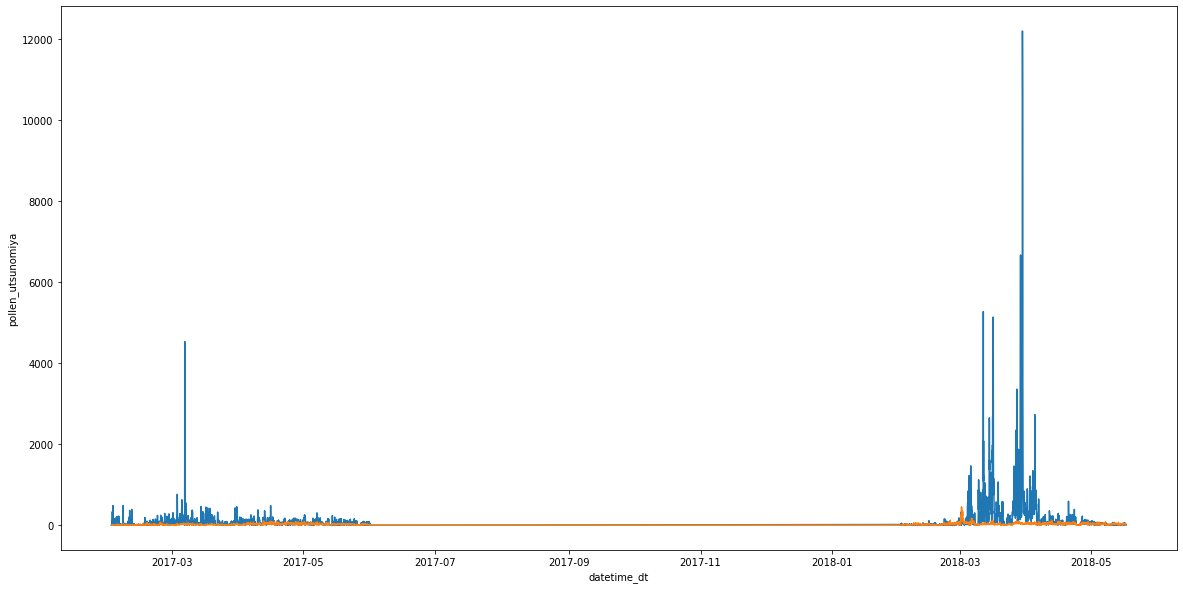

=====fold 1=======
train shape (6120, 1875) test shape (6120, 1875)
score = 70.5795197556579


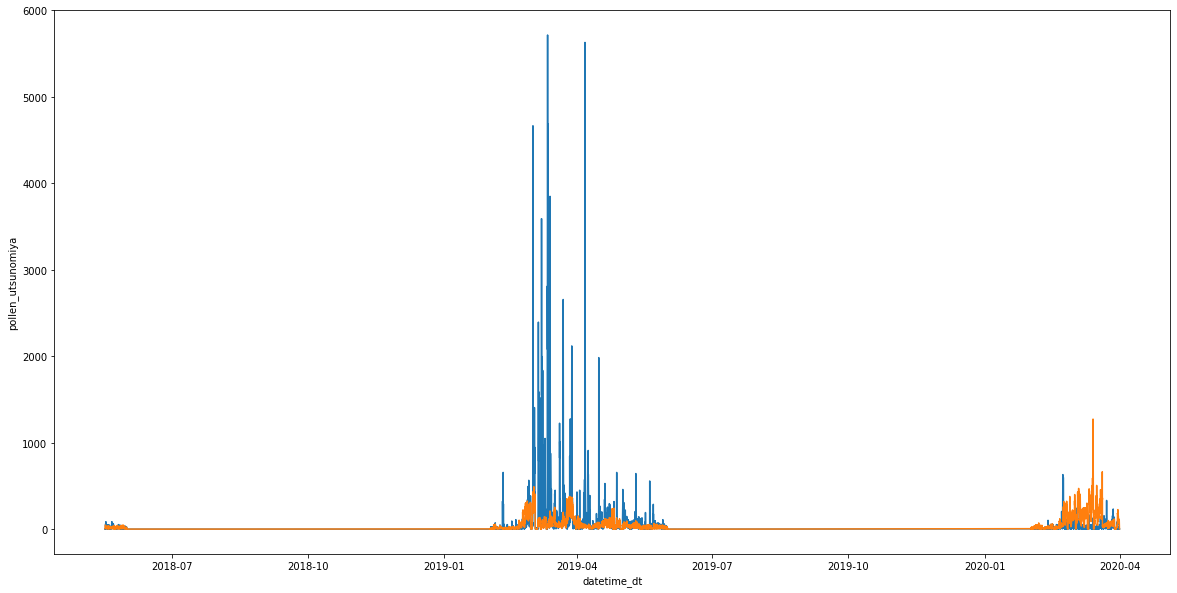

 fold_0 mae: 89.98875723579872
 fold_1 mae: 70.5795197556579
mean 80.28413849572831


In [31]:
utsunomiya_prediction, scores, df_imps = train_lightgbm_with_cv_log(
    _df,
    _df_test,
    target_label="pollen_utsunomiya",
    plot=True,
    qth=q_ut,
    unused_label=["year", "datetime", "datetime_dt"] + unused_cols,
)

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean {np.mean(scores)}")

utsunomiya_score = np.mean(scores)

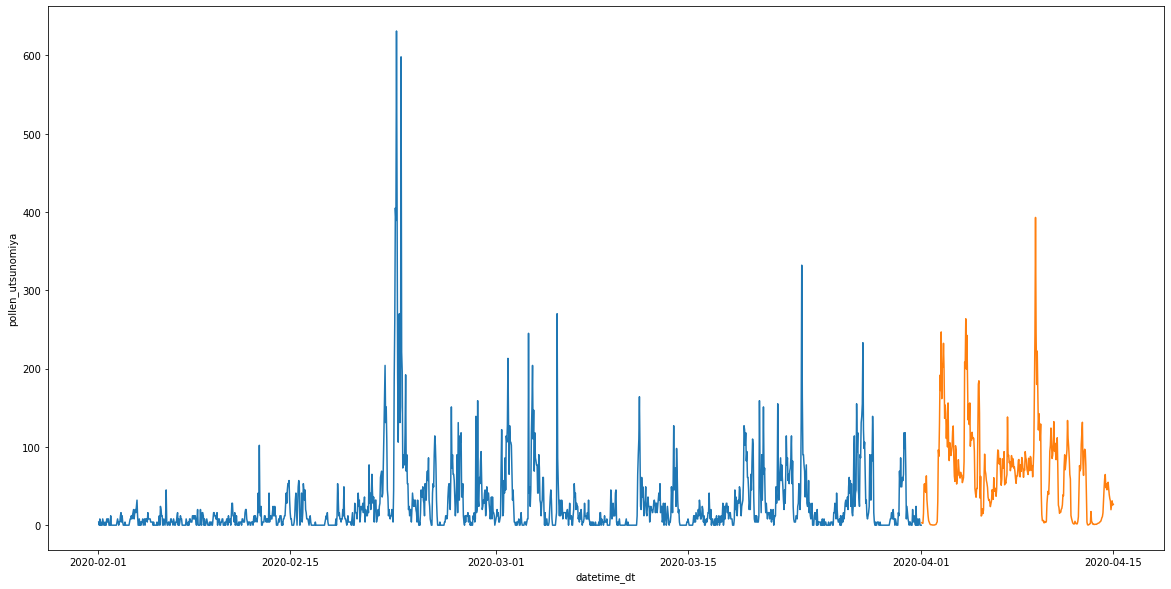

In [32]:
__df_test = _df_test.copy()
__df_test["pollen_utsunomiya"] = utsunomiya_prediction
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=_df[_df.year==2020], x="datetime_dt", y="pollen_utsunomiya")
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_utsunomiya")

<AxesSubplot:xlabel='feat_imp', ylabel='columns'>

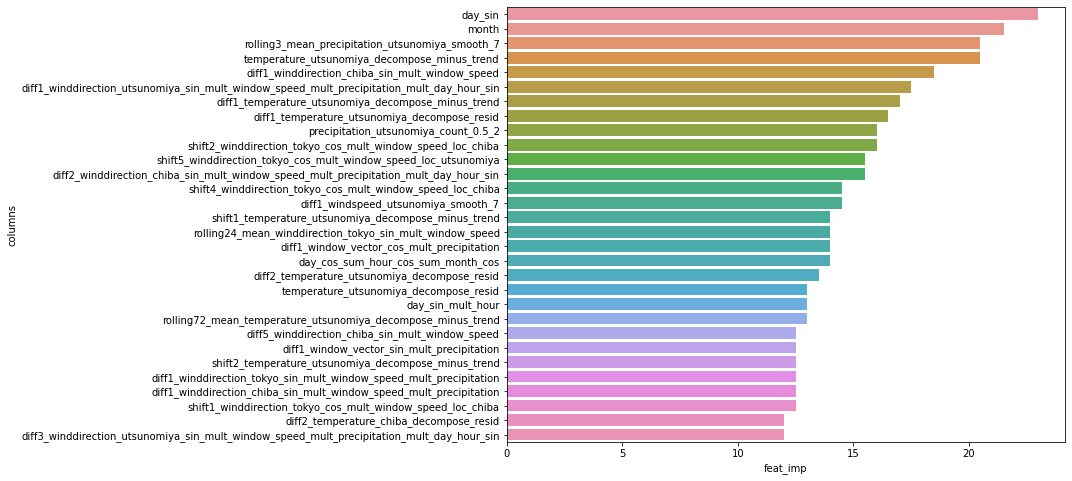

In [33]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")

# Tokyo pred

In [34]:
unused_cols = [col for col in _df.columns if ("temperature_tokyo" in col) and ("decompose" not in col)]

=========pollen_tokyo==========
qth = 20
=====fold 0=======
train shape (6120, 1875) test shape (6120, 1875)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


score = 34.15478985297775


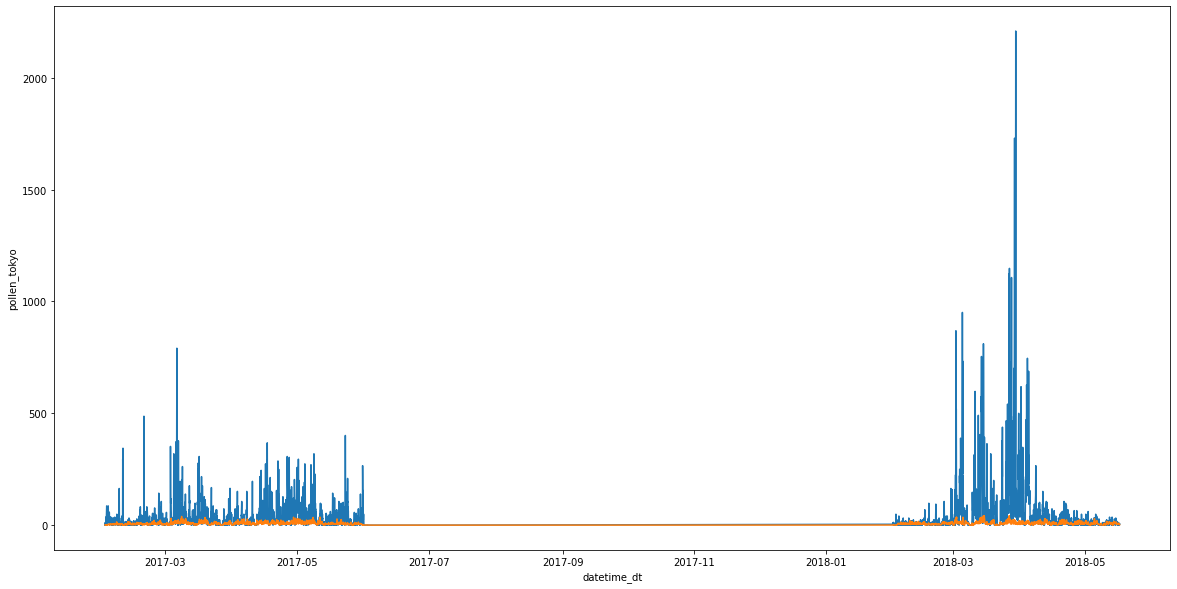

=====fold 1=======
train shape (6120, 1875) test shape (6120, 1875)
score = 15.753374719965269


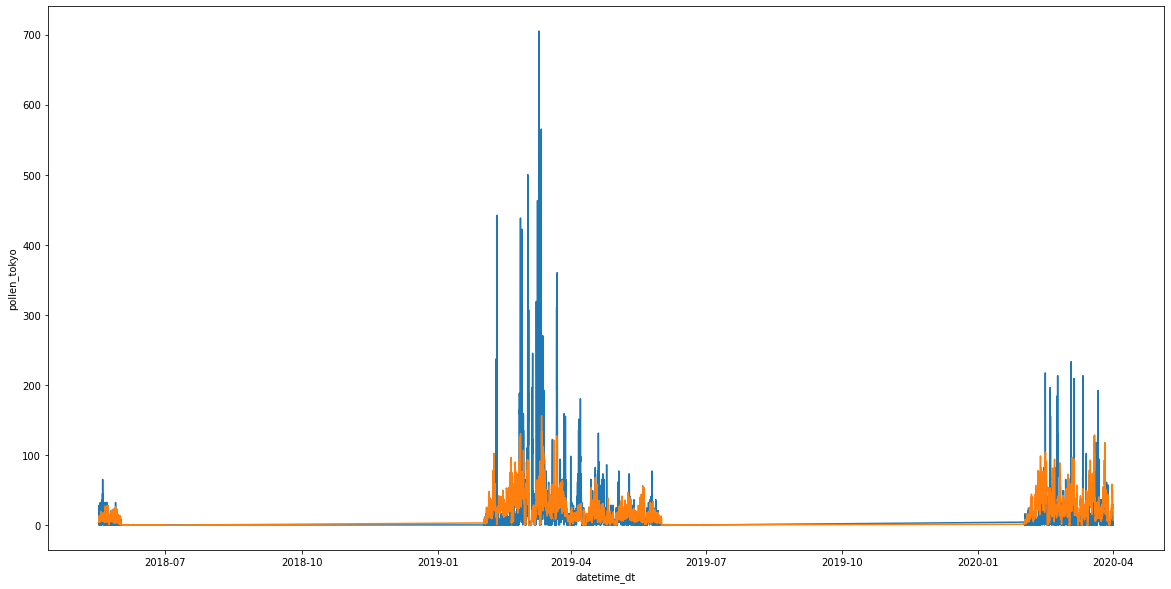

 fold_0 mae: 34.15478985297775
 fold_1 mae: 15.753374719965269
mean: 24.95408228647151


In [35]:

tokyo_prediction, scores, df_imps = train_lightgbm_with_cv_log(
    _df,
    _df_test,
    target_label="pollen_tokyo",
    plot=True,
    qth=q_tk,
    unused_label=["year", "datetime", "datetime_dt"] + unused_cols,
)


for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")

tokyo_score = np.mean(scores)

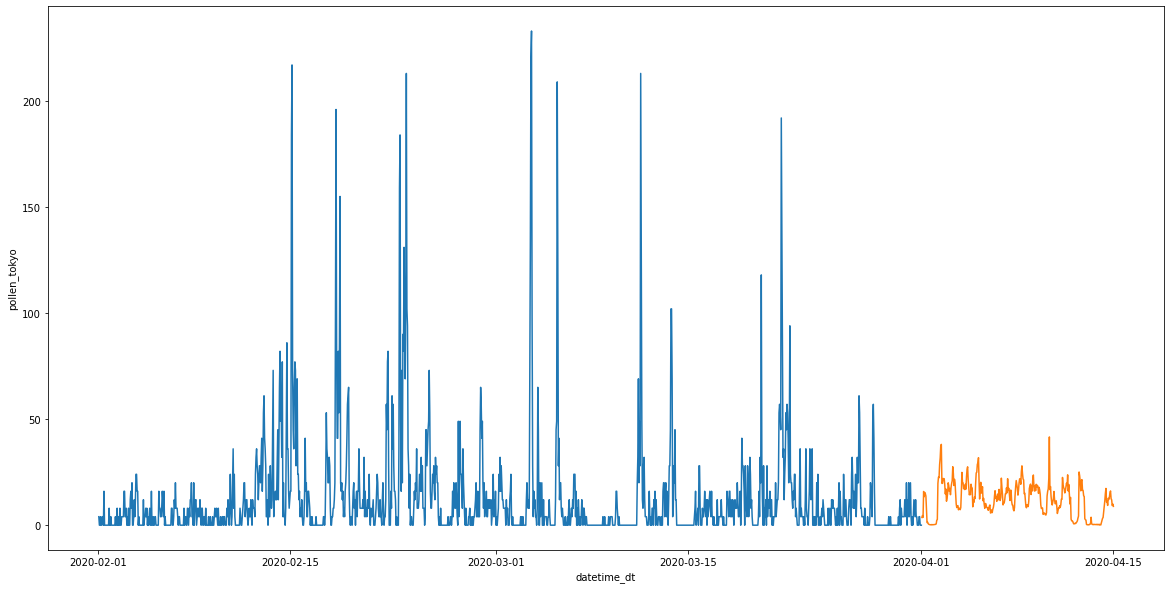

In [36]:
__df_test = _df_test.copy()
__df_test["pollen_tokyo"] = tokyo_prediction
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=_df[_df.year==2020], x="datetime_dt", y="pollen_tokyo")
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_tokyo")

<AxesSubplot:xlabel='feat_imp', ylabel='columns'>

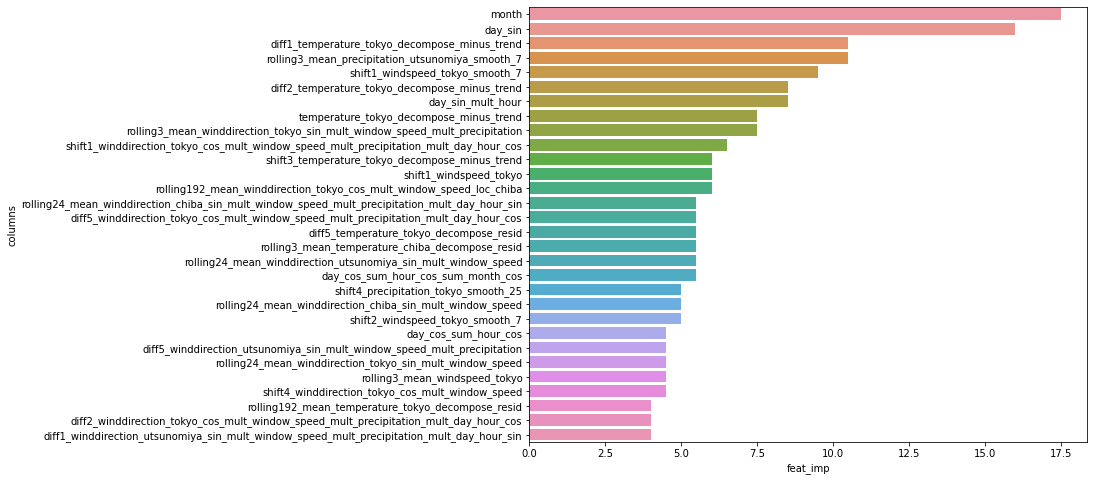

In [37]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")

# Chiba prediciton

In [38]:
#unused_cols = [col for col in _df.columns if ("temperature_chiba" in col) and ("decompose" not in col)]

=========pollen_chiba==========
qth = 20
=====fold 0=======


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


train shape (6120, 1875) test shape (6120, 1875)
score = 27.72834679837025


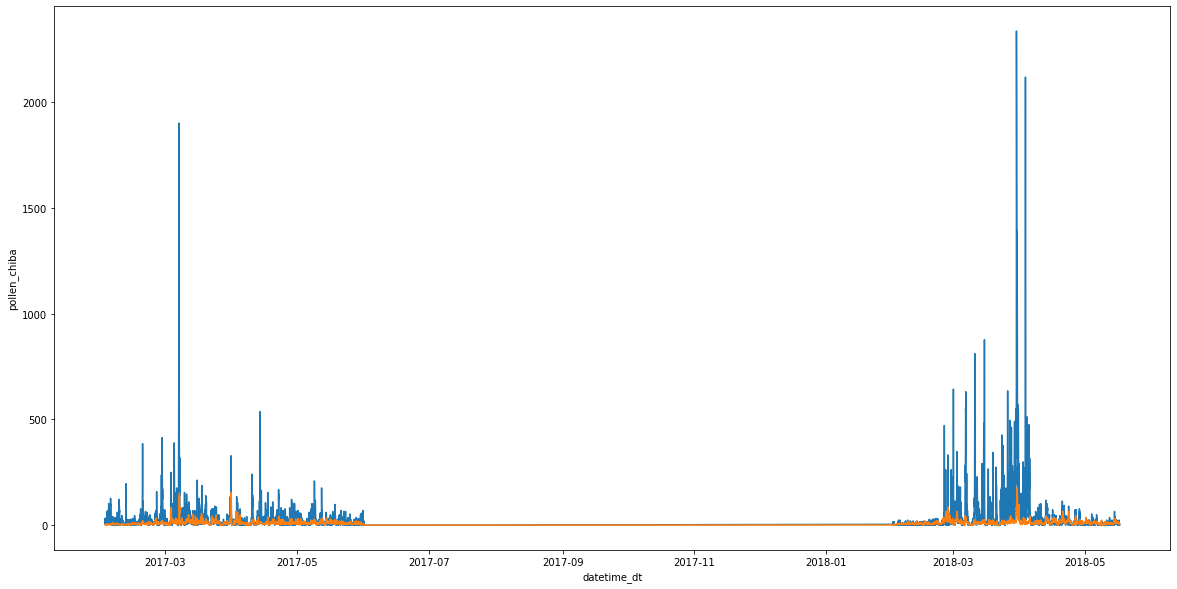

=====fold 1=======
train shape (6120, 1875) test shape (6120, 1875)
score = 21.969196748794783


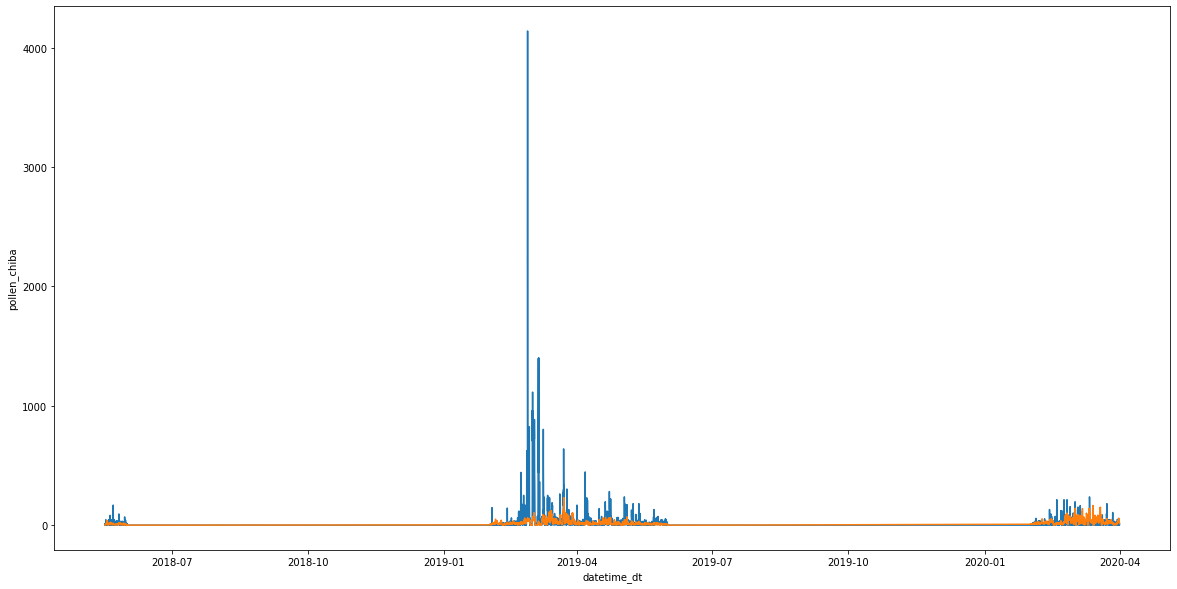

 fold_0 mae: 27.72834679837025
 fold_1 mae: 21.969196748794783
mean: 24.848771773582516


In [39]:
chiba_prediction, scores, df_imps = train_lightgbm_with_cv_log(
    _df,
    _df_test,
    target_label="pollen_chiba",
    plot=True,
    qth=q_cb,
    unused_label=["year", "datetime", "datetime_dt"] #+ unused_cols,
)

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")


chiba_score = np.mean(scores)


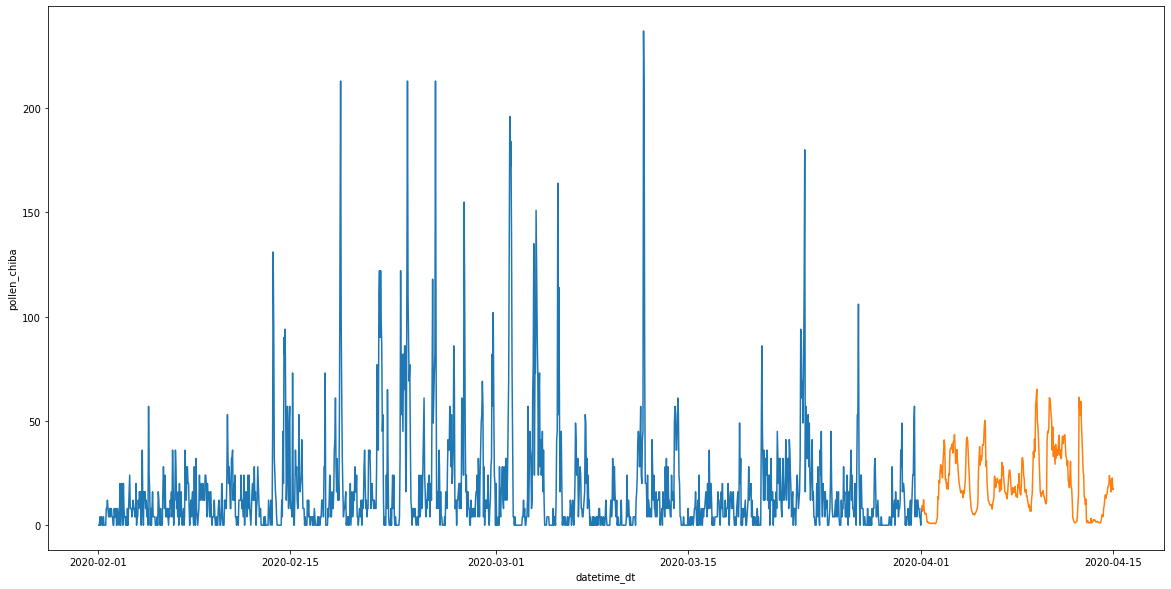

In [40]:
__df_test = _df_test.copy()
__df_test["pollen_chiba"] = chiba_prediction
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=_df[_df.year==2020], x="datetime_dt", y="pollen_chiba")
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_chiba")

<AxesSubplot:xlabel='feat_imp', ylabel='columns'>

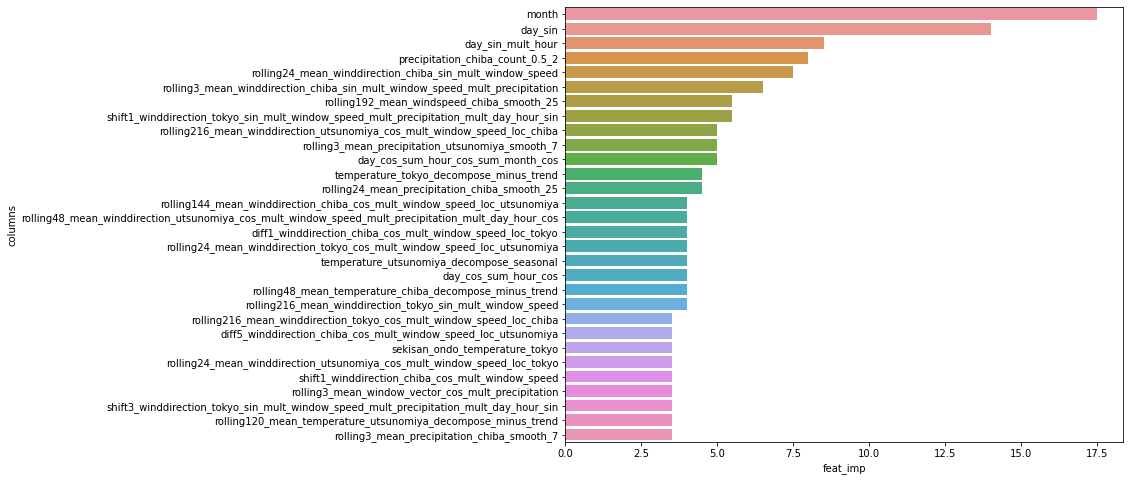

In [41]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")

# submission

In [42]:
df_sub = _df_test[["datetime"]]

In [43]:
df_sub.loc[:, "pollen_utsunomiya"] = utsunomiya_prediction
df_sub.loc[:, "pollen_chiba"] = chiba_prediction
df_sub.loc[:, "pollen_tokyo"] = tokyo_prediction

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


# 補正処理

## utsunomiya
- 202004week_0    434.422905
- 202004week_1     -0.568712

## tokyo
- 202004week_0    115.754492
- 202004week_1     -0.732169

## chiba
- 202004week_0    20.465855
- 202004week_1    -0.373396

In [44]:
utsunomiya_total_pollen_pred = 434.422905 + (-0.568712)
tokyo_total_pollen_pred = 115.754492 + (-0.732169)
chiba_total_pollen_pred = 20.465855 + (-0.373396)

# utsunomiya_total_pollen_pred = _df_ymd_test_ut["pred"].sum()
# tokyo_total_pollen_pred = _df_ymd_test_tk["pred"].sum()
# chiba_total_pollen_pred = _df_ymd_test_cb["pred"].sum()


In [45]:
# todo
#df_sub = pd.read_csv("sub.csv")

df_sub.head()

,datetime,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2020040101,3.149880,9.221586,3.626935
1,2020040102,2.481339,6.652149,4.534305
2,2020040103,2.449590,8.510251,3.670708
3,2020040104,15.220990,12.163365,15.879572
4,2020040105,51.906933,7.327422,13.434951


In [46]:
df_sub[["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"]].sum()

pollen_utsunomiya    22620.568183
pollen_chiba          6856.686658
pollen_tokyo          4143.872125
dtype: float64

In [47]:
df_sub_fix = df_sub[["datetime"]].copy()
df_sub_fix["pollen_utsunomiya"] = df_sub["pollen_utsunomiya"] * ( utsunomiya_total_pollen_pred / df_sub["pollen_utsunomiya"].sum())
df_sub_fix["pollen_chiba"] = df_sub["pollen_chiba"] * ( chiba_total_pollen_pred / df_sub["pollen_chiba"].sum())
df_sub_fix["pollen_tokyo"] = df_sub["pollen_tokyo"] * ( tokyo_total_pollen_pred / df_sub["pollen_tokyo"].sum())

In [48]:
df_sub_fix[["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"]].sum()

pollen_utsunomiya    29280.390381
pollen_chiba         14533.657890
pollen_tokyo          9194.355210
dtype: float64

In [49]:

df_sub.to_csv(f"sub.csv", index=None)

df_sub_fix.to_csv(f"sub_fix.csv", index=None)


In [50]:
df_sub_fix.sum(), 

(datetime             6.787337e+11
 pollen_utsunomiya    2.928039e+04
 pollen_chiba         1.453366e+04
 pollen_tokyo         9.194355e+03
 dtype: float64,)

In [51]:
df_sub.sum()

datetime             6.787337e+11
pollen_utsunomiya    2.262057e+04
pollen_chiba         6.856687e+03
pollen_tokyo         4.143872e+03
dtype: float64

In [52]:
utsunomiya_score, tokyo_score, chiba_score, np.mean(
    [utsunomiya_score, tokyo_score, chiba_score]
)   

(80.28413849572831, 24.95408228647151, 24.848771773582516, 43.362330851927446)

- (81.01024866938805, 25.2806610043259, 24.935926961456737, 43.74227887839023) qなしで pollen total 補正 LB: 14.47869
- (3.507674745298538, 3.8133768805137436, 3.8513519793289857, 3.724134535047089) time series k-fold -> kfold LB: 12.68535
- pollen_total の補正を使う LB: 14.51586
- (3.2992873512805874, 3.4586717988839144, 3.689065188308221, 3.4823414461575743) LB: 12.78 q = 20, 20, 20
- (3.2615237031261897, 1.803599091668639, 3.700513642291193, 2.921878812362007)

In [53]:
if not Config.mlp:
    raise ValueError("stop")

ValueError: stop

In [ ]:
_df.head()

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,...,rolling216_mean_temperature_tokyo_decompose_resid,rolling216_mean_temperature_tokyo_decompose_minus_trend,rolling216_mean_temperature_utsunomiya_decompose_trend,rolling216_mean_temperature_utsunomiya_decompose_seasonal,rolling216_mean_temperature_utsunomiya_decompose_resid,rolling216_mean_temperature_utsunomiya_decompose_minus_trend,rolling216_mean_temperature_chiba_decompose_trend,rolling216_mean_temperature_chiba_decompose_seasonal,rolling216_mean_temperature_chiba_decompose_resid,rolling216_mean_temperature_chiba_decompose_minus_trend
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16,1,2,...,0.307548,-1.881072,3.026912,-2.976872,-1.050039,-4.026912,6.658000,-2.833122,0.275122,-2.558000
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1,1,1,...,0.306531,-2.033130,3.028457,-3.281375,-0.797081,-4.078457,6.656192,-2.877097,0.370905,-2.506192
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1,15,16,...,0.272960,-2.151887,3.029974,-3.138505,-0.824802,-3.963307,6.654308,-2.803718,0.316076,-2.487642
3,2017020104,0.0,0.0,0.0,-1.1,4.4,1.8,1,15,1,...,0.295905,-2.362335,3.031460,-3.264320,-0.742140,-4.006460,6.652341,-2.720946,0.293605,-2.427341
4,2017020105,0.0,0.0,0.0,-1.2,4.1,1.5,2,14,14,...,0.206762,-2.549466,3.032916,-3.408516,-0.644400,-4.052916,6.650283,-2.751653,0.301370,-2.450283


# keras MLP

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
#from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping

In [ ]:
def generate_model(input_dim):
    model = Sequential()

    model.add(Dense(1024, input_dim=input_dim))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(500, input_dim=1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, input_dim=500))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, input_dim=100))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, input_dim=1))
    model.compile(optimizer='Adam', loss='mean_absolute_error', metrics=['mae'])    
    return model

In [ ]:
from sklearn.preprocessing import Normalizer, StandardScaler


def train_keras(
    __df: pd.DataFrame,  # 学習データ
    __df_test: pd.DataFrame,  # テストデータ
    target_label: str,  # target label
    label_cols: List[str] = ["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo",],
    unused_label: List[str] = ["datetime", "datetime_dt",],
    plot: bool = False,
    qth: int = 20,
) -> Union[np.array, List[np.float]]:

    _df = __df.copy()
    df_test = __df_test.copy()
    _df = _df.fillna(-1)
    df_test = df_test.fillna(-1)
        
    print(f"========={target_label}==========")
    print(f"qth = {qth}")
    
    cols = [col for col in _df.columns if col not in label_cols + unused_label]

    folds = TimeSeriesSplit(n_splits=Config.n_splits)
    scores = []
    prediction = np.zeros(len(df_test))    

    for fold, (train_idx, val_idx) in enumerate(folds.split(_df)):
        print(f"=====fold {fold}=======")
                
        df_train = _df.iloc[train_idx].reset_index(drop=True)
        df_val = _df.iloc[val_idx].reset_index(drop=True)

        print("train shape", df_train.shape, "test shape", df_val.shape)

        label = target_label
        
        # # データがv2になってから花粉飛散量がマイナスのがある。削除する。
        df_train = df_train[df_train[label] >= 0].reset_index(drop=True)
        df_val = df_val[df_val[label] >= 0].reset_index(drop=True)
        
        df_train = df_train[df_train[label] <= qth].reset_index(drop=True)
        df_val = df_val[df_val[label] <= qth].reset_index(drop=True)

        normalizer = Normalizer().fit(df_train[cols])    
        X = normalizer.transform(df_train[cols])
        
        val_X = normalizer.transform(df_val[cols])
        
        model = generate_model(df_train[cols].shape[1])

        early_stopping = EarlyStopping(
                            monitor='val_mae',
                            min_delta=0.0,
                            patience=100,
        )

        model.fit(X , np.log1p(df_train[label]), validation_data=(val_X, np.log1p(df_val[label])),
                  epochs=500, batch_size=128, callbacks=[early_stopping])      

        # validation
        val_pred = model.predict(val_X)
        val_pred = np.expm1(val_pred)
        val_score = mean_absolute_error(df_val[label], val_pred)
        scores.append(val_score)
        
        if plot:
            _df_val = df_val.copy()
            _df_val["pred"] = val_pred
            plt.figure(figsize=(10, 6))
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y=label)
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y="pred")
            plt.show()
            
        test_X = normalizer.transform(df_test[cols])

        _pred = model.predict(test_X)
        _pred = _pred.flatten()
        _pred = np.expm1(_pred)
        prediction += _pred / Config.n_splits
        prediction = np.where(prediction < 0, 0, prediction)

    return prediction, scores

# Utsunomiya prediction

In [ ]:
unused_cols = [col for col in _df.columns if (("temperature_utsunomiya" in col) and ("decompose" not in col)) or ("one_hot" in col)]

=========pollen_utsunomiya==========
qth = 20
=====fold 0=======
train shape (4080, 1878) test shape (4080, 1878)


2022-11-23 10:32:54.924997: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN

Epoch 1/500
19/19 [==============================] - 1s 29ms/step - loss: 1.0031 - mae: 1.0031 - val_loss: 0.9083 - val_mae: 0.9083
Epoch 2/500
19/19 [==============================] - 0s 20ms/step - loss: 0.9028 - mae: 0.9028 - val_loss: 0.8788 - val_mae: 0.8788
Epoch 3/500
19/19 [==============================] - 0s 20ms/step - loss: 0.8597 - mae: 0.8597 - val_loss: 0.8284 - val_mae: 0.8284
Epoch 4/500
19/19 [==============================] - 0s 20ms/step - loss: 0.7948 - mae: 0.7948 - val_loss: 0.7922 - val_mae: 0.7922
Epoch 5/500
19/19 [==============================] - 0s 20ms/step - loss: 0.7558 - mae: 0.7558 - val_loss: 0.7571 - val_mae: 0.7571
Epoch 6/500
19/19 [==============================] - 0s 19ms/step - loss: 0.7036 - mae: 0.7036 - val_loss: 0.7433 - val_mae: 0.7433
Epoch 7/500
19/19 [==============================] - 0s 21ms/step - loss: 0.6911 - mae: 0.6911 - val_loss: 0.7748 - val_mae: 0.7748
Epoch 8/500
19/19 [==============================] - 0s 19ms/step - loss: 0.

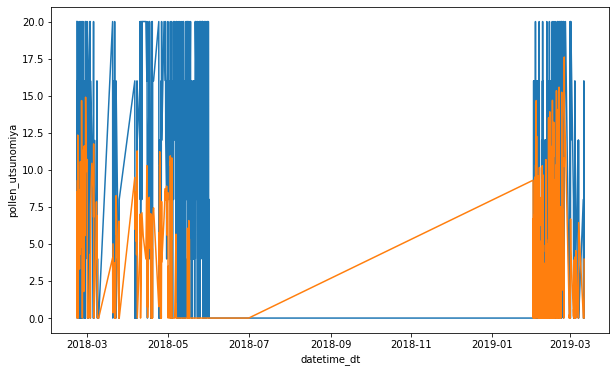

=====fold 1=======
train shape (8160, 1878) test shape (4080, 1878)
Epoch 1/500
36/36 [==============================] - 1s 22ms/step - loss: 0.9602 - mae: 0.9602 - val_loss: 0.9141 - val_mae: 0.9141
Epoch 2/500
36/36 [==============================] - 1s 17ms/step - loss: 0.8567 - mae: 0.8567 - val_loss: 0.8221 - val_mae: 0.8221
Epoch 3/500
36/36 [==============================] - 1s 17ms/step - loss: 0.7733 - mae: 0.7733 - val_loss: 0.7407 - val_mae: 0.7407
Epoch 4/500
36/36 [==============================] - 1s 18ms/step - loss: 0.7276 - mae: 0.7276 - val_loss: 0.7141 - val_mae: 0.7141
Epoch 5/500
36/36 [==============================] - 1s 17ms/step - loss: 0.7063 - mae: 0.7063 - val_loss: 0.6717 - val_mae: 0.6717
Epoch 6/500
36/36 [==============================] - 1s 17ms/step - loss: 0.6482 - mae: 0.6482 - val_loss: 0.6433 - val_mae: 0.6433
Epoch 7/500
36/36 [==============================] - 1s 18ms/step - loss: 0.6463 - mae: 0.6463 - val_loss: 0.6444 - val_mae: 0.6444
Epoch 8/

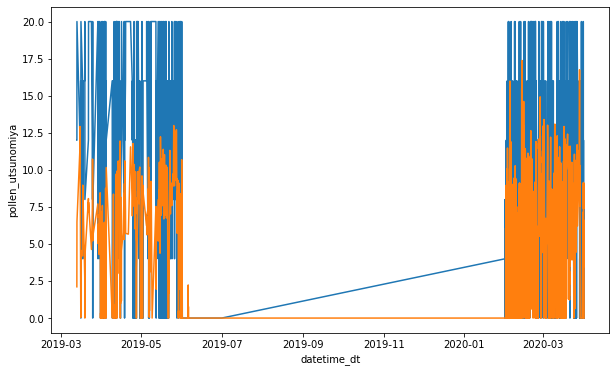

 fold_0 mae: 4.048542348939023
 fold_1 mae: 3.734057504480166
mean 3.8912999267095945


In [ ]:
utsunomiya_prediction, scores = train_keras(
   _df.copy(), _df_test, target_label="pollen_utsunomiya", plot=True, qth=q_ut, unused_label=["year", "datetime", "datetime_dt"] + unused_cols,
)


for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean {np.mean(scores)}")

utsunomiya_score_mlp = np.mean(scores)

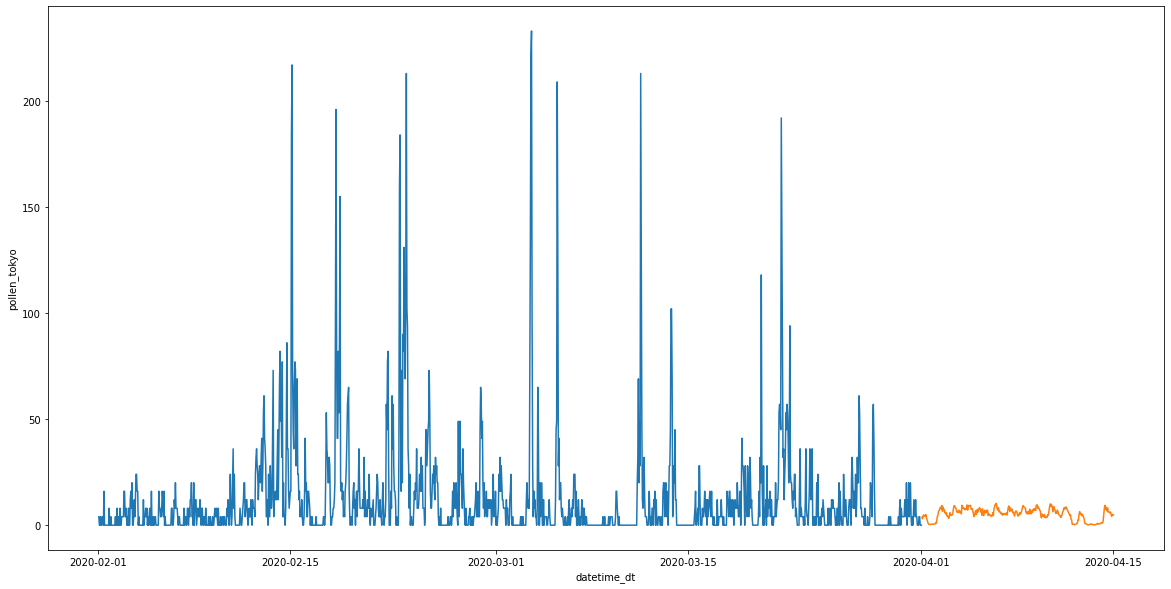

In [ ]:
__df_test = _df_test.copy()
__df_test["pollen_tokyo"] = tokyo_prediction
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=_df[_df.year==2020], x="datetime_dt", y="pollen_tokyo")
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_tokyo")

# tokyo pred

In [ ]:
unused_cols = [col for col in _df.columns if (("temperature_tokyo" in col) and ("decompose" not in col)) or ("one_hot" in col)]

=========pollen_tokyo==========
qth = 20
=====fold 0=======
train shape (4080, 1878) test shape (4080, 1878)
Epoch 1/500
23/23 [==============================] - 1s 26ms/step - loss: 1.1186 - mae: 1.1186 - val_loss: 0.9879 - val_mae: 0.9879
Epoch 2/500
23/23 [==============================] - 1s 23ms/step - loss: 1.0051 - mae: 1.0051 - val_loss: 0.9221 - val_mae: 0.9221
Epoch 3/500
23/23 [==============================] - 0s 20ms/step - loss: 0.9087 - mae: 0.9087 - val_loss: 0.8898 - val_mae: 0.8898
Epoch 4/500
23/23 [==============================] - 0s 20ms/step - loss: 0.8453 - mae: 0.8453 - val_loss: 0.8231 - val_mae: 0.8231
Epoch 5/500
23/23 [==============================] - 0s 20ms/step - loss: 0.7717 - mae: 0.7717 - val_loss: 0.7461 - val_mae: 0.7461
Epoch 6/500
23/23 [==============================] - 0s 20ms/step - loss: 0.7467 - mae: 0.7467 - val_loss: 0.8119 - val_mae: 0.8119
Epoch 7/500
23/23 [==============================] - 0s 21ms/step - loss: 0.7180 - mae: 0.7180 - va

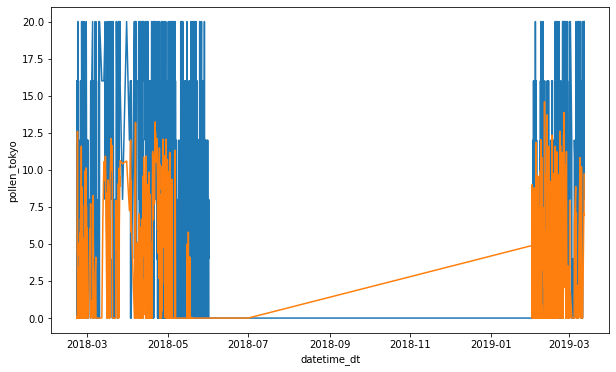

=====fold 1=======
train shape (8160, 1878) test shape (4080, 1878)
Epoch 1/500
45/45 [==============================] - 1s 21ms/step - loss: 1.0076 - mae: 1.0076 - val_loss: 0.8866 - val_mae: 0.8866
Epoch 2/500
45/45 [==============================] - 1s 18ms/step - loss: 0.8504 - mae: 0.8504 - val_loss: 0.7734 - val_mae: 0.7734
Epoch 3/500
45/45 [==============================] - 1s 18ms/step - loss: 0.7806 - mae: 0.7806 - val_loss: 0.7501 - val_mae: 0.7501
Epoch 4/500
45/45 [==============================] - 1s 18ms/step - loss: 0.7292 - mae: 0.7292 - val_loss: 0.7883 - val_mae: 0.7883
Epoch 5/500
45/45 [==============================] - 1s 17ms/step - loss: 0.7036 - mae: 0.7036 - val_loss: 0.7260 - val_mae: 0.7260
Epoch 6/500
45/45 [==============================] - 1s 18ms/step - loss: 0.6840 - mae: 0.6840 - val_loss: 0.6875 - val_mae: 0.6875
Epoch 7/500
45/45 [==============================] - 1s 18ms/step - loss: 0.6450 - mae: 0.6450 - val_loss: 0.6762 - val_mae: 0.6762
Epoch 8/

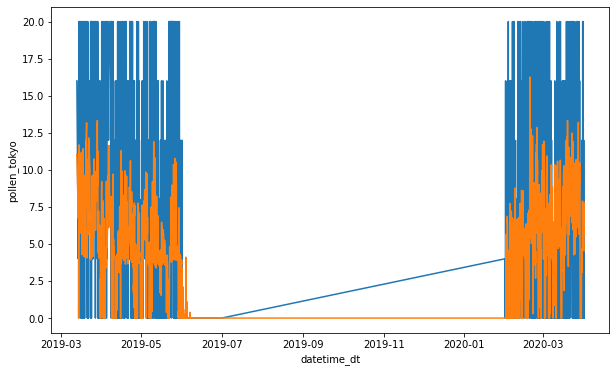

 fold_0 mae: 3.76509425174619
 fold_1 mae: 3.612536871742123
mean: 3.6888155617441565


In [ ]:
tokyo_prediction, scores = train_keras(
    _df.copy(), _df_test, target_label="pollen_tokyo", plot=True, qth=q_tk, unused_label=["year", "datetime", "datetime_dt"] + unused_cols
)

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")

tokyo_score_mlp = np.mean(scores)

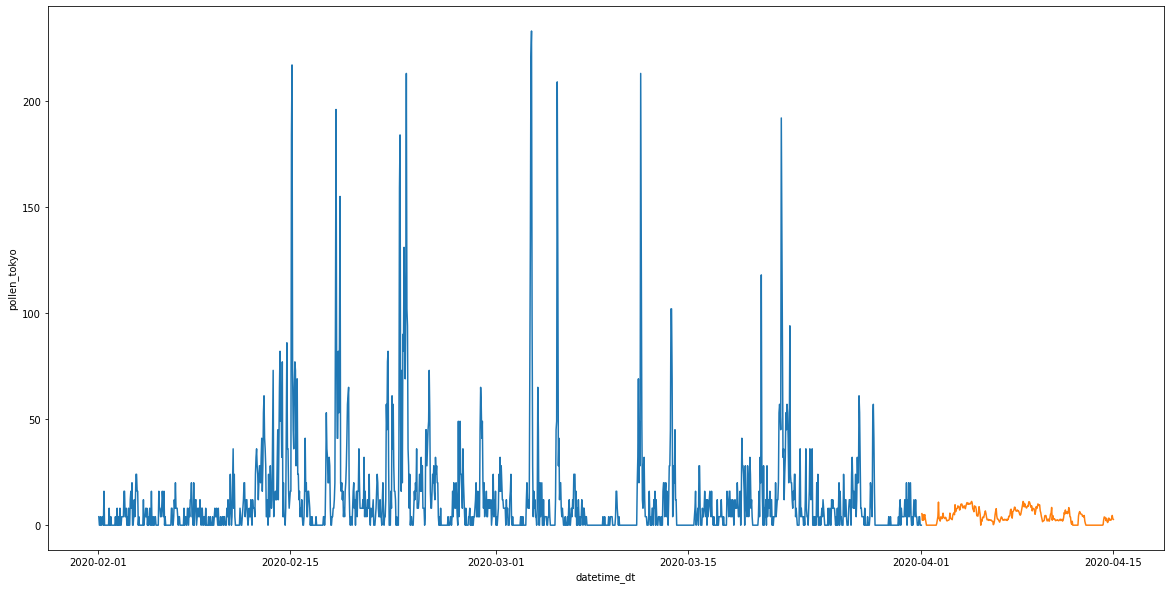

In [ ]:
__df_test = _df_test.copy()
__df_test["pollen_tokyo"] = tokyo_prediction
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=_df[_df.year==2020], x="datetime_dt", y="pollen_tokyo")
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_tokyo")

# chiba pred

In [ ]:
unused_cols = [col for col in _df.columns if ("one_hot" in col)]

=========pollen_chiba==========
qth = 20
=====fold 0=======
train shape (4080, 1878) test shape (4080, 1878)
Epoch 1/500
24/24 [==============================] - 1s 29ms/step - loss: 1.0511 - mae: 1.0511 - val_loss: 0.9352 - val_mae: 0.9352
Epoch 2/500
24/24 [==============================] - 0s 21ms/step - loss: 0.9122 - mae: 0.9122 - val_loss: 0.9011 - val_mae: 0.9011
Epoch 3/500
24/24 [==============================] - 0s 21ms/step - loss: 0.8472 - mae: 0.8472 - val_loss: 0.8295 - val_mae: 0.8295
Epoch 4/500
24/24 [==============================] - 0s 20ms/step - loss: 0.8108 - mae: 0.8108 - val_loss: 0.8339 - val_mae: 0.8339
Epoch 5/500
24/24 [==============================] - 1s 22ms/step - loss: 0.7667 - mae: 0.7667 - val_loss: 0.8149 - val_mae: 0.8149
Epoch 6/500
24/24 [==============================] - 0s 20ms/step - loss: 0.7630 - mae: 0.7630 - val_loss: 0.8059 - val_mae: 0.8059
Epoch 7/500
24/24 [==============================] - 0s 20ms/step - loss: 0.7381 - mae: 0.7381 - va

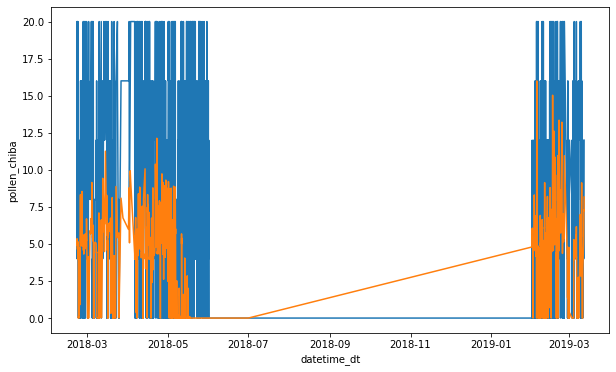

=====fold 1=======
train shape (8160, 1878) test shape (4080, 1878)
Epoch 1/500
46/46 [==============================] - 1s 21ms/step - loss: 0.9934 - mae: 0.9934 - val_loss: 0.8287 - val_mae: 0.8287
Epoch 2/500
46/46 [==============================] - 1s 18ms/step - loss: 0.8483 - mae: 0.8483 - val_loss: 0.7687 - val_mae: 0.7687
Epoch 3/500
46/46 [==============================] - 1s 18ms/step - loss: 0.7933 - mae: 0.7933 - val_loss: 0.7574 - val_mae: 0.7574
Epoch 4/500
46/46 [==============================] - 1s 19ms/step - loss: 0.7609 - mae: 0.7609 - val_loss: 0.6855 - val_mae: 0.6855
Epoch 5/500
46/46 [==============================] - 1s 18ms/step - loss: 0.7425 - mae: 0.7425 - val_loss: 0.6954 - val_mae: 0.6954
Epoch 6/500
46/46 [==============================] - 1s 18ms/step - loss: 0.7220 - mae: 0.7220 - val_loss: 0.7523 - val_mae: 0.7523
Epoch 7/500
46/46 [==============================] - 1s 21ms/step - loss: 0.7217 - mae: 0.7217 - val_loss: 0.6462 - val_mae: 0.6462
Epoch 8/

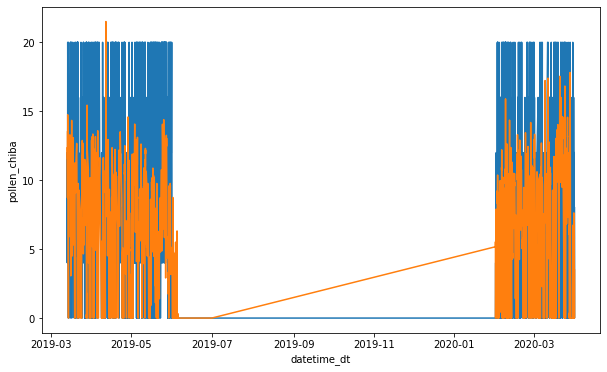

 fold_0 mae: 4.104735084933067
 fold_1 mae: 3.795484441159971
mean: 3.9501097630465187


In [ ]:
chiba_prediction, scores = train_keras(
   _df.copy(), _df_test, target_label="pollen_chiba", plot=True, qth=q_cb
)

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")


chiba_score_mlp = np.mean(scores)

In [ ]:
df_sub_mlp = _df_test[["datetime"]]
df_sub_mlp.loc[:, "pollen_utsunomiya"] = utsunomiya_prediction
df_sub_mlp.loc[:, "pollen_chiba"] = chiba_prediction
df_sub_mlp.loc[:, "pollen_tokyo"] = tokyo_prediction

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
print("====mlp score====")
utsunomiya_score_mlp, tokyo_score_mlp, chiba_score_mlp, np.mean(
    [utsunomiya_score_mlp, tokyo_score_mlp, chiba_score_mlp]
)

====mlp score====


(3.8912999267095945,
 3.6888155617441565,
 3.9501097630465187,
 3.8434084171667564)

In [ ]:
print("==== lgbm score ====")
utsunomiya_score, tokyo_score, chiba_score, np.mean(
    [utsunomiya_score, tokyo_score, chiba_score]
)

==== lgbm score ====


(3.301623812879706, 3.4760406943250937, 3.6944679764401718, 3.490710827881657)

# Emsemble

In [ ]:
cols = ["pollen_tokyo"]
df_final_sub = df_sub.copy()
df_subs = [df_sub_mlp]

In [ ]:
for col in cols:
    for _df in df_subs:        
        df_final_sub[col] += _df[col]
        
    df_final_sub[col] = df_final_sub[col] / (len(df_subs) + 1)

In [ ]:
df_final_sub.to_csv("sub.csv", index=None)

In [ ]:
df_final_sub.head()

,datetime,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2020040101,3.254020,2.864844,4.576456
1,2020040102,2.835438,3.828365,2.642924
2,2020040103,2.408286,3.452884,4.650268
3,2020040104,1.588979,1.910947,3.629909
4,2020040105,2.921656,2.047789,4.107957


In [ ]:
df_sub.head()

,datetime,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2020040101,3.254020,2.864844,3.716969
1,2020040102,2.835438,3.828365,2.979822
2,2020040103,2.408286,3.452884,4.342066
3,2020040104,1.588979,1.910947,4.863504
4,2020040105,2.921656,2.047789,4.164041


In [ ]:
df_sub_mlp.head()

,datetime,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2020040101,3.647612,2.271482,5.435943
1,2020040102,2.827804,1.822823,2.306026
2,2020040103,4.149288,1.047481,4.958470
3,2020040104,2.038247,0.000297,2.396314
4,2020040105,5.217808,0.333046,4.051873
